In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
import nugget
from conflictfree.grad_operator import ConFIG_update
import time
from scipy.stats import gaussian_kde
from IPython.display import clear_output
import matplotlib.pyplot as plt
import importlib

In [2]:
Skewedgauss = nugget.surrogates.SkewedGaussian.SkewedGaussian()
light_yield_surrogate = Skewedgauss.light_yield_surrogate
signal_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='signal')
background_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='background')


In [3]:
signal_event = signal_sampler.sample_events(1)
coordinate = signal_sampler.sample_detector_points(1)

In [4]:
coordinate

tensor([[ 0.1574, -0.4247,  0.0610]])

In [5]:
light_yield_surrogate(opt_point=coordinate, event_params=signal_event[0])

tensor([0.7855])

In [6]:
llr_net = nugget.surrogates.LLRnet.LLRnet(
    dim=3,
    hidden_dims=[256, 128, 64],
    use_fourier_features=True,
    num_parallel_branches=2,
    frequency_scales=[0.1, 0.2],  # Different scales for each branch
    num_frequencies_per_branch=[64,64],
    learnable_frequencies=False,
    dropout_rate=0.1,
    learning_rate=1e-3,
    shared_mlp=False,  # Use shared MLP across branches
    use_residual_connections=True,
    signal_noise_scale=0.05,
    background_noise_scale=0.2,
    add_relative_pos=True
)

In [7]:
train_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler, 
                                                   background_sampler = background_sampler,
                                                   batch_size=64, 
                                                   num_workers=2,
                                                   signal_surrogate_func=light_yield_surrogate,
                                                   background_surrogate_func=light_yield_surrogate,
                                                   num_samples_per_epoch=2000,
                                                   event_labels=['position', 'energy', 'zenith', 'azimuth'])
val_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                 background_sampler = background_sampler,
                                                 batch_size=2, 
                                                 num_workers=2,
                                                 signal_surrogate_func=light_yield_surrogate,
                                                 background_surrogate_func=light_yield_surrogate,
                                                 num_samples_per_epoch=500,
                                                 event_labels=['position', 'energy', 'zenith', 'azimuth'])
test_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                  background_sampler = background_sampler,
                                                  batch_size=1, 
                                                  num_workers=2,
                                                  signal_surrogate_func=light_yield_surrogate,
                                                  background_surrogate_func=light_yield_surrogate,
                                                  num_samples_per_epoch=1000,
                                                  event_labels=['position', 'energy', 'zenith', 'azimuth'])

In [8]:
history = llr_net.train_with_dataloader(train_dataloader=train_dataloader,
                                       val_dataloader=val_dataloader,
                                       epochs=200,
                                       early_stopping_patience=25)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Building parallel network architecture:
  Input dim: 13
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Final MLP: 128 -> 64 -> 1
  Total trainable parameters: 247,297


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/200, Train Loss: 0.6743, Val Loss: 0.6738
Epoch 20/200, Train Loss: 0.6616, Val Loss: 0.6613
Epoch 30/200, Train Loss: 0.6560, Val Loss: 0.6435
Epoch 40/200, Train Loss: 0.6448, Val Loss: 0.6673
Epoch 50/200, Train Loss: 0.6459, Val Loss: 0.6358
Epoch 60/200, Train Loss: 0.6431, Val Loss: 0.6325
Epoch 70/200, Train Loss: 0.6408, Val Loss: 0.6582
Early stopping at epoch 74


1000 1000 1000

Evaluation Results:
Accuracy: 0.6370
AUC: 0.6916
Precision: 0.7069
Recall: 0.4680


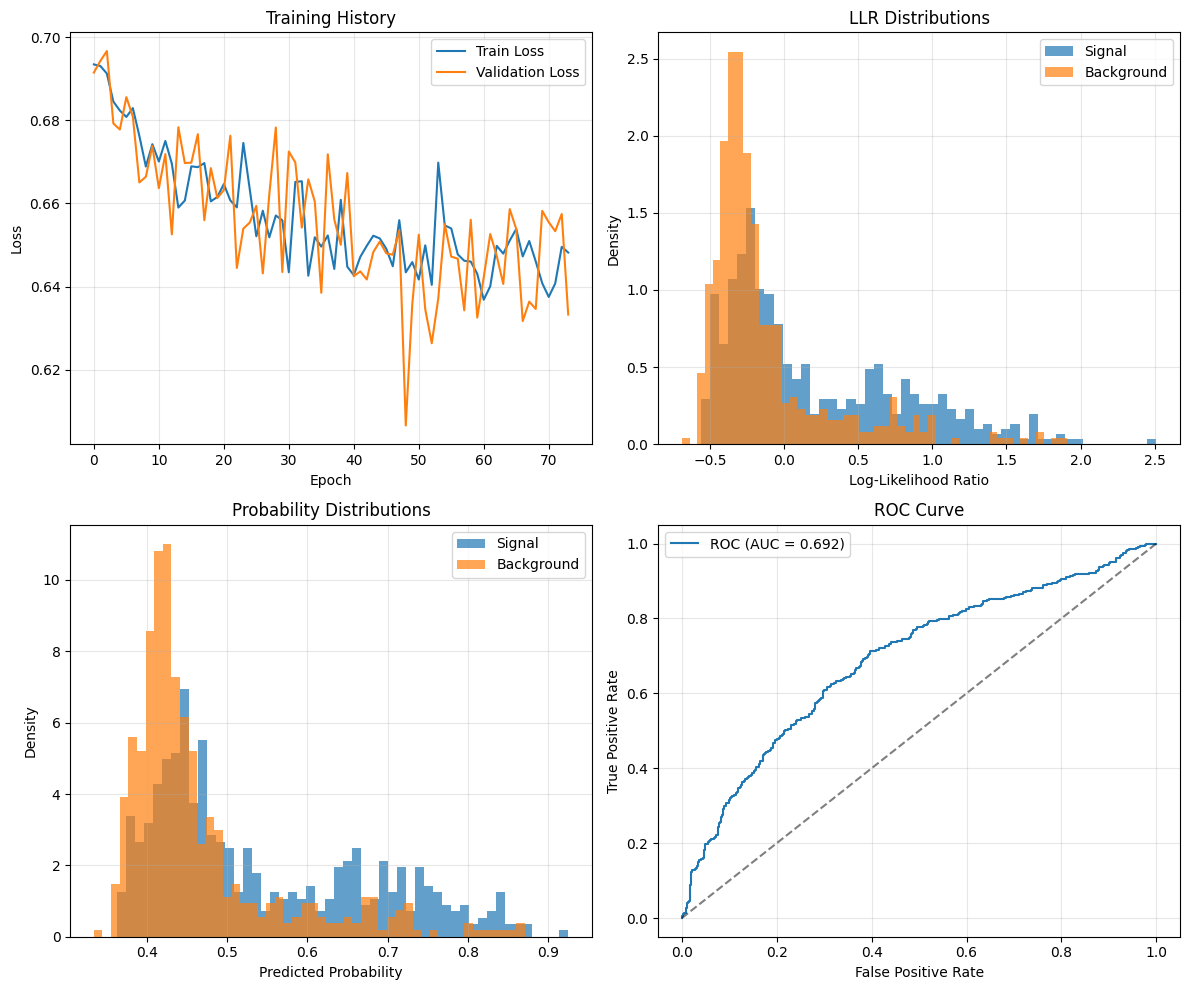

In [9]:
predictions = []
true_labels = []
llr_values = []
all_features = []
with torch.no_grad():
    for features, labels, in test_dataloader:
        # Get LLR predictions
        batch_llr = llr_net.predict_log_likelihood_ratio(features)
        batch_probs = llr_net.predict_proba(features)
        # print(len(batch_llr), len(batch_probs), len(labels))
        
        llr_values.extend(batch_llr.cpu().numpy())
        predictions.extend(batch_probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_features.extend(features.cpu().numpy())  # Store features for further analysis
        # denoised_values.extend(denoised.cpu().numpy())

# Convert to numpy arrays
llr_values = np.array(llr_values)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
all_features = np.array(all_features).squeeze()  # Remove batch dimension if needed
# denoised_values = np.array(denoised_values)
print(len(llr_values), len(predictions), len(true_labels))

# Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

binary_preds = (predictions > 0.5).astype(int)
accuracy = accuracy_score(true_labels, binary_preds)
auc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, binary_preds)
recall = recall_score(true_labels, binary_preds)

print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training history
axes[0,0].plot(history['train_loss'], label='Train Loss')
axes[0,0].plot(history['val_loss'], label='Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training History')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LLR distributions
signal_mask = true_labels == 1
background_mask = true_labels == 0

axes[0,1].hist(llr_values[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[0,1].hist(llr_values[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[0,1].set_xlabel('Log-Likelihood Ratio')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('LLR Distributions')
# axes[0,1].set_xlim(-5, 5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Probability distributions
axes[1,0].hist(predictions[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[1,0].hist(predictions[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Probability Distributions')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
axes[1,1].plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [144]:
new_signal_events = signal_sampler.sample_events(100)
new_background_events = background_sampler.sample_events(100)

In [271]:
importlib.reload(nugget.geometries.EvanescentString)
geometry = nugget.geometries.EvanescentString.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=500,
        points_per_string=10,
        starting_weight=-1,
        )

In [272]:
importlib.reload(nugget.utils.basic_optimizer)
importlib.reload(nugget.losses.LLR)
importlib.reload(nugget.losses.fisher_info)
importlib.reload(nugget.losses.light_yield)
importlib.reload(nugget.losses.geometry_penalties)
importlib.reload(nugget.utils.vis_tools)
visualizer = nugget.utils.vis_tools.Visualizer(
                                device=geometry.device,
                                dim=geometry.dim, 
                                domain_size=geometry.domain_size,
                                gif_temp_dir='gif_temp'
        )
optimizer = nugget.utils.basic_optimizer.Optimizer(
                        device=geometry.device, 
                        geometry=geometry,
                        visualizer=visualizer,
                        conflict_free=False
                        )
optimizer.init_geometry(opt_list=[('string_weights',0.1)])

Optimizing string_weights with torch.Size([500]) shape


In [273]:
signal_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
                    device=geometry.device,
                    LLRnet=llr_net,
                    noise_scale=0.05,
                    )
background_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
                    device=geometry.device,
                    LLRnet=llr_net,
                    noise_scale=0.2,
                    )
signal_yield_loss_func = nugget.losses.light_yield.WeightedLightYieldLoss(
                            device=geometry.device,
                            noise_scale=0.05
                                )
fisher_info_loss_func = nugget.losses.fisher_info.WeightedFisherInfoLoss(
    device=geometry.device,
        )
weighted_dif_llr_loss = nugget.losses.LLR.WeightedMeanDifLLRLoss(
    device=geometry.device)

local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device)

string_weights_penalty = nugget.losses.geometry_penalties.StringWeightsPenalty(
    device=geometry.device)

string_number_penalty = nugget.losses.geometry_penalties.StringNumberPenalty(
    device=geometry.device)

weighted_binarization_penalty = nugget.losses.geometry_penalties.WeightBinarizationPenalty(
    device=geometry.device)

loss_params = {
    'llr_net': llr_net,
    'signal_event_params': new_signal_events,   
    'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,
    'background_surrogate_func': light_yield_surrogate,
    'signal_sampler': signal_sampler,
    'background_sampler': background_sampler,
    'num_events': 100
}

loss_params.update({
    'eva_min_num_strings': 70,
    'max_radius': 0.08
})
loss_func_dict = {
                # 'fisher_loss': fisher_info_loss_func, 
                # 'signal_yield_loss': signal_yield_loss_func,
                'signal_llr_loss': signal_llr_loss_func,
                'mean_dif_llr_loss': weighted_dif_llr_loss,
                'local_string_repulsion_penalty': local_string_repulsion_penalty,
                'string_weights_penalty': string_weights_penalty,
                'string_number_penalty': string_number_penalty,
            #   'weight_binarization_penalty': weighted_binarization_penalty
                }

loss_weights_dict = {
                # 'fisher_loss': 1e4, 
                # 'signal_yield_loss': 5e2,
                'signal_llr_loss': 100,
                'mean_dif_llr_loss': 1,
                'local_string_repulsion_penalty': 0.01,
                'string_weights_penalty': 1,
                'string_number_penalty': 0.1,
            #   'weight_binarization_penalty': 0.01
                }

plot_types = [
            'loss_components', 
            'llr_histogram', 
            'string_weights_scatter',
            'signal_llr_contour', 
            'background_llr_contour', 
            # 'signal_light_yield_contour',
            # 'fisher_info_logdet'
            ]
vis_kwargs = {
            'plot_types':plot_types,
            'slice_res':50,
            'multi_slice':True,
            'gif_plot_selection': plot_types
            }

In [216]:
precomputed_signal_llr_per_string = signal_llr_loss_func.compute_LLR_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points'],
                            event_params=new_signal_events,
                            surrogate_func=light_yield_surrogate
                                )
precomputed_background_llr_per_string = background_llr_loss_func.compute_LLR_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points'],
                            event_params=new_background_events,
                            surrogate_func=light_yield_surrogate
                                )

/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/losses/LLR.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features.append(torch.tensor(self.llr_net.prepare_data_from_raw(point, params, surrogate_func, self.event_labels, self.noise_scale), device=self.device))


In [ ]:
precomputed_signal_yield_per_string = signal_yield_loss_func.light_yield_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points'],
                            event_params=new_signal_events,
                            surrogate_func=light_yield_surrogate
                                )

In [ ]:
precomputed_fisher_info_per_string = fisher_info_loss_func.compute_fisher_info_per_string(
                            string_xy=optimizer.geom_dict['string_xy'],
                            points_3d=optimizer.geom_dict['points'],
                            signal_event_params=new_signal_events,
                            signal_surrogate_func=light_yield_surrogate
                                )

In [274]:
loss_params.update({
    'precomputed_signal_llr_per_string': precomputed_signal_llr_per_string,
    'precomputed_background_llr_per_string': precomputed_background_llr_per_string,
    'precomputed_signal_yield_per_string': precomputed_signal_yield_per_string,
    'precomputed_fisher_info_per_string': precomputed_fisher_info_per_string,
})

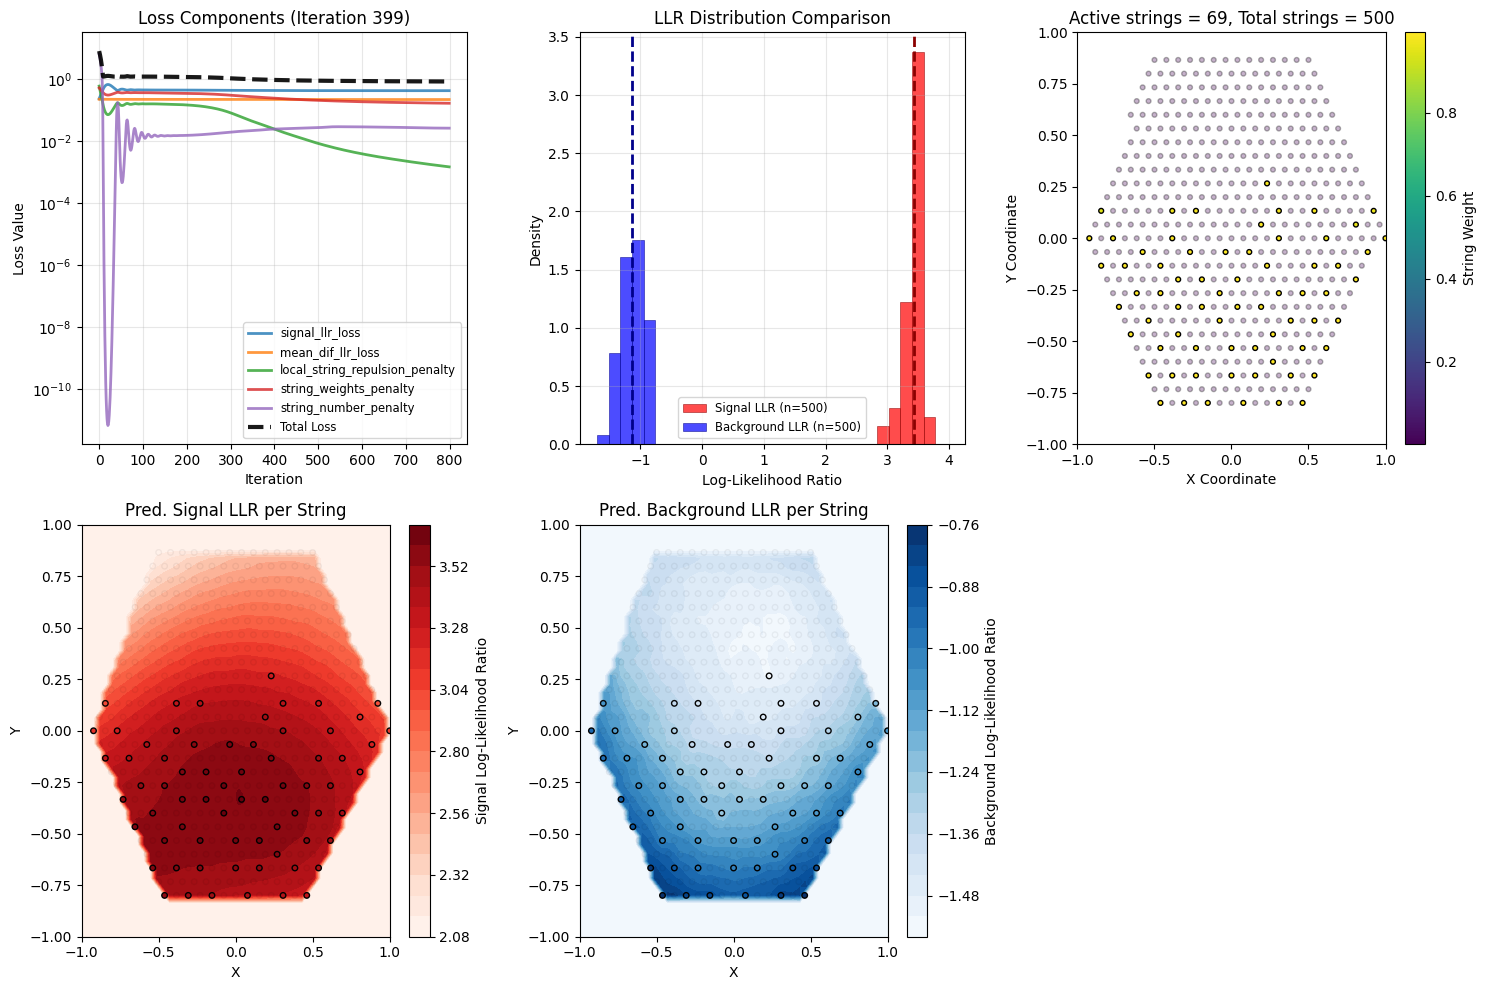

Saved GIF frame 162 to gif_temp/frame_32559.png


In [276]:
# optimizer.visualizer.cleanup_gif_temp_files()
geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,
    loss_weights_dict=loss_weights_dict,
    loss_params_dict=loss_params,
    n_iter=400,
    vis_kwargs=vis_kwargs,
    print_freq=5,
    vis_freq=20,
    gif_freq=5,
    loss_dict=optimizer.loss_dict,
    uw_loss_dict=optimizer.uw_loss_dict,
    vis_loss_dict=optimizer.vis_loss_dict,
    vis_uw_loss_dict=optimizer.vis_uw_loss_dict  
)

In [277]:
optimizer.visualizer.finalize_gif(
    gif_filename='../gifs/new_nugget_test.gif',
    gif_fps=10,
    cleanup_images=False)

Successfully compiled GIF '../gifs/new_nugget_test.gif' with 162 frames.


True

In [ ]:
# geom_dict['weight_threshold'] = 0.7

In [301]:
importlib.reload(nugget.geometries.DynamicString)
# importlib.reload(nugget.utils.basic_optimizer)
# importlib.reload(nugget.utils.vis_tools)
new_geometry = nugget.geometries.DynamicString.DynamicString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        )

In [302]:
visualizer = nugget.utils.vis_tools.Visualizer(
                                device=new_geometry.device,
                                dim=new_geometry.dim, 
                                domain_size=new_geometry.domain_size,
                                gif_temp_dir='gif_temp'
        )
optimizer = nugget.utils.basic_optimizer.Optimizer(
                        device=new_geometry.device, 
                        geometry=new_geometry,
                        visualizer=visualizer,
                        conflict_free=False
                        )
optimizer.init_geometry(opt_list=[('string_xy',0.01),('z_values',0.01)], geom_dict=geom_dict)

Using pre-trained dynamic string geometry as starting point
Filtering strings: 69 out of 500 strings active
Filtered string_xy to 69 strings
Filtered z_values from 5000 to 690 points
Created per-point string_indices for active strings, total_points now: 690
Optimizing string_xy with torch.Size([69, 2]) shape
Optimizing z_values with torch.Size([690]) shape


In [303]:
importlib.reload(nugget.losses.LLR)
# importlib.reload(nugget.losses.fisher_info)
# importlib.reload(nugget.losses.light_yield)
importlib.reload(nugget.losses.geometry_penalties)
signal_llr_loss_func = nugget.losses.LLR.LLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    noise_scale=0.05,
                    )
background_llr_loss_func = nugget.losses.LLR.LLRLoss(
                    device=geometry.device,
                    llr_net=llr_net,
                    noise_scale=0.2,
                    )
signal_yield_loss_func = nugget.losses.light_yield.LightYieldLoss(
                            device=geometry.device,
                            noise_scale=0.05
                                )
fisher_info_loss_func = nugget.losses.fisher_info.FisherInfoLoss(
    device=geometry.device,
        )
weighted_dif_llr_loss = nugget.losses.LLR.MeanDifLLRLoss(
    llr_net=llr_net,
    device=geometry.device)

local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device)

local_z_distance_repulsion_penalty = nugget.losses.geometry_penalties.LocalZDistRepulsionPenalty(
    device=geometry.device)

boundary_penalty = nugget.losses.geometry_penalties.BoundaryPenalty(
    device=geometry.device)



loss_params = {
    'llr_net': llr_net,
    # 'signal_event_params': new_signal_events,   
    # 'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,
    'background_surrogate_func': light_yield_surrogate,
    'signal_sampler': signal_sampler,
    'background_sampler': background_sampler,
    'num_events': 10
}

loss_params.update({
    'domain_size': 2,
    'max_radius': 0.08
})
loss_func_dict = {
                # 'fisher_loss': fisher_info_loss_func, 
                # 'signal_yield_loss': signal_yield_loss_func,
                'signal_llr_loss': signal_llr_loss_func,
                'mean_dif_llr_loss': weighted_dif_llr_loss,
                'local_string_repulsion_penalty': local_string_repulsion_penalty,
                'local_z_dist_repulsion_penalty': local_z_distance_repulsion_penalty,
                'boundary_penalty': boundary_penalty
                }

loss_weights_dict = {
                # 'fisher_loss': 1e4, 
                # 'signal_yield_loss': 5e2,
                'signal_llr_loss': 100,
                'mean_dif_llr_loss': 1,
                'local_string_repulsion_penalty': 0.01,
                'local_z_distance_repulsion_penalty': 0.01,
                'boundary_penalty': 0.01
            #   'weight_binarization_penalty': 0.01
                }

plot_types = [
            'loss_components', 
            '3d_points',
            'llr_histogram_points', 
            'xy_projection',
            'signal_llr_contour', 
            'background_llr_contour',
            # 'signal_light_yield_contour',
            # 'fisher_info_logdet'
            ]
vis_kwargs = {
            'plot_types':plot_types,
            'slice_res':50,
            'multi_slice':True,
            'gif_plot_selection': plot_types
            }

In [304]:
new_geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,
    loss_weights_dict=loss_weights_dict,
    loss_params_dict=loss_params,
    n_iter=400,
    vis_kwargs=vis_kwargs,
    print_freq=5,
    vis_freq=20,
    gif_freq=5,
    alternate_freq=10 
)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn